### Parte 1 - Coleta de trend topics

In [491]:
# 1.1 - importa bibliotecas
import pandas as pd
from pymongo import MongoClient
from datetime import datetime, timedelta
import json
import copy

In [492]:
import numpy as np
import tweepy
import requests
import base64

In [493]:
import os
import sys
from nltk import word_tokenize
from string import punctuation

In [494]:
from oauth2client.service_account import ServiceAccountCredentials
import gspread
from gspread_dataframe import set_with_dataframe

In [495]:
# 1.2 - trata chaves do twitter
consumer_key = 'xpto1'
consumer_secret_key = 'xpto2'

In [496]:
key_secret = '{}:{}'.format(consumer_key, consumer_secret_key).encode('ascii')
b64_encoded_key = base64.b64encode(key_secret)
b64_encoded_key = b64_encoded_key.decode('ascii')

In [497]:
# 1.3 - autentica no twitter
base_url = 'https://api.twitter.com/'
auth_url = '{}oauth2/token'.format(base_url)
auth_headers = {
    'Authorization': 'Basic {}'.format(b64_encoded_key),
    'Content-Type': 'application/x-www-form-urlencoded;charset=UTF-8'
}
auth_data = {
    'grant_type': 'client_credentials'
}
auth_resp = requests.post(auth_url, headers=auth_headers, data=auth_data)
access_token = auth_resp.json()['access_token']

In [498]:
# 1.4 - acessa os trends WW, (id WW=1, id BR=23424768)

trend_headers = {
    'Authorization': 'Bearer {}'.format(access_token)    
}
trend_params = {
     'id': 1,
}
trend_url = 'https://api.twitter.com/1.1/trends/place.json' 

trend_resp_a = requests.get(trend_url, headers=trend_headers, params=trend_params)
list_fnew_ww = trend_resp_a.json()

trend_params = {
     'id': 23424768, #23424925,portugal     #23424768, brasil
}

trend_resp_b = requests.get(trend_url, headers=trend_headers, params=trend_params)
list_fnew_br = trend_resp_b.json()

In [499]:
# 1.5 - formata os trends WW removendo colunas desnecessárias

In [500]:
for element in list_fnew_ww[0]['trends']:
    if 'url' in element:
        del element['url']
    if 'query' in element:
        del element['query']
    if 'promoted_content' in element:
        del element['promoted_content']    

if 'locations' in list_fnew_ww[0]:        
    del (list_fnew_ww[0]['locations'])

if 'as_of' in list_fnew_ww[0]:        
    del (list_fnew_ww[0]['as_of'])

if 'created_at' in list_fnew_ww[0]:
    (list_fnew_ww[0]['created_at']) = datetime.today().replace(microsecond=0)
    
list_first_ww = copy.deepcopy(list_fnew_ww)

In [501]:
# 1.6 - formata os trends BR removendo colunas desnecessárias

In [502]:
for element in list_fnew_br[0]['trends']:
    if 'url' in element:
        del element['url']
    if 'query' in element:
        del element['query']
    if 'promoted_content' in element:
        del element['promoted_content']    

if 'locations' in list_fnew_br[0]:        
    del (list_fnew_br[0]['locations'])

if 'as_of' in list_fnew_br[0]:        
    del (list_fnew_br[0]['as_of'])

if 'created_at' in list_fnew_br[0]:
    (list_fnew_br[0]['created_at']) = datetime.today().replace(microsecond=0)

list_first_br = copy.deepcopy(list_fnew_br) 

In [503]:
# 1.7 conecta no MongoDB e grava as coleções WW e BR

In [504]:
client = MongoClient('localhost', 27017)
db = client['twitter_db']

collection = db['twitter_lst_ww']
collection.insert_many(list_fnew_ww)

collection = db['twitter_lst_br']
collection.insert_many(list_fnew_br)

### Parte 2 - Gera as tabelas

In [505]:
# 2.1 - Busca o primeiro registro(BR e WW) no MongoDB com tempo maior que uma hora

In [506]:
x = datetime.today().replace(microsecond=0)
x = x + timedelta(hours=-1)

In [507]:
fold_br = collection.find({"created_at" : { "$lte" : x }}).sort("created_at",-1);    
list_fold_br = list(fold_br)

In [508]:
collection = db['twitter_lst_ww']

fold_ww = collection.find({"created_at" : { "$lte" : x }}).sort("created_at",-1);    
list_fold_ww = list(fold_ww)

client.close()

In [509]:
# 2.2 - Aponta o ponteiro para a parte significativa do registro de 1h BR
tnow_br = (list_fnew_br[0]['trends'])
told_br = (list_fold_br[0]['trends'])

In [510]:
# 2.3 - limpa as listas BR removendo os 'nulls' e gera a tabela da ultima hora emcima do 
#       ponteiro que veio da consulta inicial. A seguir gera o dataframe com esta tabela.

for i in range(0,len(tnow_br)):
    if tnow_br[i]['tweet_volume'] == None:
        tnow_br[i]['tweet_volume'] = 0

for i in range(0,len(told_br)):
    if told_br[i]['tweet_volume'] == None:
        told_br[i]['tweet_volume'] = 0

for i in range(0,len(tnow_br)):
    for j in range(0,len(told_br)):
        if tnow_br[i]['name'] in told_br[j]['name']:           
            (tnow_br[i]['tweet_volume']) = (tnow_br[i]['tweet_volume']) - (told_br[j]['tweet_volume'])

#dfbr1 = dataframe com a diferença entre os volumes do 'tt' agora e 1 hora atrás no brasil
dfbr1 = pd.DataFrame(tnow_br)
dfbr1.sort_values(by=['tweet_volume'], inplace=True, ascending=False)
dfbr1.reset_index(drop=True, inplace=True)
#dfbr1.head(40)



In [511]:
# 2.4 - Aponta o ponteiro para a parte significativa do registro de 1h WW
tnow_ww = (list_fnew_ww[0]['trends'])
told_ww = (list_fold_ww[0]['trends'])

In [512]:
# 2.5 - limpa as listas WW removendo os 'nulls' e gera a tabela da ultima hora emcima do 
#       ponteiro que veio da consulta inicial. A seguir gera o dataframe com esta tabela.

for i in range(0,len(tnow_ww)):
    if tnow_ww[i]['tweet_volume'] == None:
        tnow_ww[i]['tweet_volume'] = 0

for i in range(0,len(told_ww)):
    if told_ww[i]['tweet_volume'] == None:
        told_ww[i]['tweet_volume'] = 0

for i in range(0,len(tnow_ww)):
    for j in range(0,len(told_ww)):
        if tnow_ww[i]['name'] in told_ww[j]['name']:           
            (tnow_ww[i]['tweet_volume']) = (tnow_ww[i]['tweet_volume']) - (told_ww[j]['tweet_volume'])

#dfww1 = dataframe com a diferença entre os volumes do 'tt' agora e 1 hora atrás mundial
dfww1 = pd.DataFrame(tnow_ww)
dfww1.sort_values(by=['tweet_volume'], inplace=True, ascending=False)
dfww1.reset_index(drop=True, inplace=True)
#dfww1.head(10)

In [513]:
#dfwwt = dataframe gerado com os dados da lista da consulta inicial ao 'tt' mundial, antes de sua edição
dfwwt = pd.DataFrame(list_first_ww[0]['trends'])
dfwwt.reset_index(drop=True, inplace=True)
#dfwwt.head(10)

### Parte 3 - Analise de Sentimentos

In [514]:
# 3.1 - Classe para classificação das mensagens usando o algoritmo Naive Bayes

sys.path.append(f"{os.getcwd()}/")

class EmotionNaiveClassifier:
    
    def __init__(self, path=""):
        self.alegria = pd.read_csv(f"{path}alegria", header=None)
        self.surpresa = pd.read_csv(f"{path}surpresa", header=None)
        self.confianca = pd.read_csv(f"{path}confianca", header=None)
        self.desgosto = pd.read_csv(f"{path}desgosto", header=None)
        self.medo = pd.read_csv(f"{path}medo", header=None)
        self.raiva = pd.read_csv(f"{path}raiva", header=None)
        self.tristeza = pd.read_csv(f"{path}tristeza", header=None)
        
        self.alegria.columns = ["emocao"]
        self.surpresa.columns = ["emocao"]
        self.confianca.columns = ["emocao"]
        self.desgosto.columns = ["emocao"]
        self.medo.columns = ["emocao"]
        self.raiva.columns = ["emocao"]
        self.tristeza.columns = ["emocao"]
    
        self.dataset = list(zip(
            ["alegria", "surpresa", "confiança", "desgosto", "medo", "raiva", "tristeza"],
            [self.alegria, self.surpresa, self.confianca, self.desgosto, self.medo, self.raiva, self.tristeza]
        ))
    
    def predict(self, phrase):
        coef_ = {
            "alegria": 0,
            "surpresa": 0,
            "confiança": 0,
            "desgosto": 0,
            "medo": 0,
            "raiva": 0,
            "tristeza": 0
        }
        verificar_negacao = True if "não" in phrase or "sem" in phrase else False
        
        phrase = [word for word in word_tokenize(phrase.lower()) if word not in punctuation]
        for i, word in enumerate(phrase):
            for sent, df in self.dataset:
                wd_ = df[df["emocao"] == word]
                if wd_.size > 0:
                    negando = False
                    
                    if verificar_negacao:
                        for m in range(5):
                            if i-m >= 0:
                                if phrase[i-m] == "não" or phrase[i-m] == "sem":
                                    negando = True
                                    break

                    if not negando:
                        coef_[sent] += 1
                    else:
                        if sent == "surpresa":
                            coef_["tristeza"] += 0.25
                        elif sent == "confiança":
                            coef_["tristeza"] += 0.15
                            coef_["medo"] += 0.25
                        elif sent == "alegria":
                            coef_["tristeza"] += 0.15
                            coef_["desgosto"] += 0.25
                        elif sent == "desgosto":
                            coef_["alegria"] += 0.25
                        elif sent == "tristeza":
                            coef_["alegria"] += 0.25
                            coef_["confiança"] += 0.15

        coef_ = {sent: round(val, 3) for sent, val in coef_.items()}
        coef_["tristeza"] += coef_["medo"] * 1e-1
        coef_["confiança"] -= coef_["medo"] * 1e-1
        coef_["confiança"] = 0.0 if coef_["confiança"] < 0.0 else coef_["confiança"]
        coef_["raiva"] += coef_["medo"] * 1e-2
        coef_["raiva"] += coef_["desgosto"] * 1e-2
        coef_["alegria"] += coef_["confiança"] * 1e-2
        coef_["alegria"] += coef_["surpresa"] * 1e-2
        coef_ = {sent: round((val / (100 / len(phrase))) * 100, 2) for sent, val in coef_.items()}
        return coef_

In [515]:
# 3.2 - Altera os paramentros da API de busca no tweeter para buscar as frases
search_headers2 = {
    'Authorization': 'Bearer {}'.format(access_token)    
}
search_url2 = 'https://api.twitter.com/1.1/search/tweets.json'  

In [516]:
# 3.3 - Aqui está todo o centro da mágica de classificação emocional! Um loop é feito com os primeiros [qtd_tt] 
#       'tt' BR. Para cada um destes, [contador] frases serão coletadas. Cada frase é analisada individualmente 
#       e tem sua classificação emocional registrada. Para cada tt é criada uma linha num dataframe registrando a 
#       somatória classificada de seu emocional. Após a analise dos tt, a 'keyword' de busca é mudada para
#       'carrefour', para obtermos as últimas [contador] menções de carrefour no twitter, e também fazermos sua
#       análise emocional. A grande jogada de usar 'carrefour' como último é que o ponteiro sairá daqui setado 
#       em sua lista de frases, para podermos facilmente usá-las!

clf = EmotionNaiveClassifier(path=f"{os.getcwd()}/emocoes/")

alegria, surpresa, confiança, tristeza, medo, raiva, desgosto = [], [], [], [], [], [], []
lists=[alegria, surpresa, confiança, tristeza, medo, raiva, desgosto]
listsnames=["alegria", "surpresa", "confiança", "tristeza", "medo", "raiva", "desgosto"]

frase="a"
contador = 40
qtd_tt = 20

df3 = pd.DataFrame(  clf.predict(frase), 
                    columns = ['alegria' , 'surpresa', 'confiança', 'desgosto', 'medo', 'raiva', 'tristeza'],
                    index=[0]) 
df4 = pd.DataFrame(  clf.predict(frase), 
                    columns = ['indx','nome','volume','sent_maior','volume_sent_maior'],
                    index=[0]) 

for j in range(0,(qtd_tt+1)): # loop das mençoes
    flag_first=1
    frases = []
    alegria, surpresa, confiança, tristeza, medo, raiva, desgosto = [], [], [], [], [], [], []    

    if j < qtd_tt : #lista dos 'qtd_tt' mais trop trendings
        search_params2 = {
        'q': list_fnew_br[0]['trends'][j]['name'],
        'lang': 'pt',
        'result_type': 'mixed',
        'count':contador
        }
    else :  #finaliza usando o carrefour
        search_params2 = {
        'q': 'carrefour',
        'lang': 'pt',
        'result_type': 'recent',
        'count':contador
        }        
    
    for i in range(0,contador):  #loop das frases para analise de sentimento 
        if flag_first == 1:
            search_resp2 = requests.get(search_url2, headers=search_headers2, params=search_params2)
            search_data2 = search_resp2.json()
            flag_first = 0
        frases.append(search_data2['statuses'][i]['text'])
    
    for frase in frases: #carrega lista de frases
        teste = (max(clf.predict(frase), key=clf.predict(frase).get)) # traça o sentimento mais adequado p/ a frase
        
        if teste == 'alegria':
            alegria.append(frase)        
        if teste == 'surpresa':
            surpresa.append(frase)        
        if teste == 'confiança':
            confiança.append(frase)        
        if teste == 'tristeza':
            tristeza.append(frase)        
        if teste == 'medo':
            medo.append(frase)        
        if teste == 'raiva':
            raiva.append(frase)        
        if teste == 'desgosto':
            desgosto.append(frase)
            
    most_num = max(len(alegria), len(surpresa), len(confiança), len(tristeza), len(medo), len(raiva), len(desgosto))
    most= listsnames[np.argmax([len(alegria), len(surpresa), len(confiança), len(tristeza), len(medo), len(raiva), len(desgosto)])]      
 
    game1 =[ len(alegria), len(surpresa), len(confiança), len(tristeza), len(medo), len(raiva), len(desgosto)]
    game2 =[str(j+1),list_first_br[0]['trends'][j]['name'],list_first_br[0]['trends'][j]['tweet_volume'],most,most_num]
    
#    print("----inicio--------")
#    print(list_fnew_br[0]['trends'][j]['name'],"=",most,":" ,most_num,"/",len(frases))    
#    print(list_fnew_br[0]['trends'][j]['name'])
#    print(list_first_br[0]['trends'][j]['name'])
#    print(clf.predict(frase))
#    print("----fim--------")    
    
    df3.loc[j] = game1
    df4.loc[j] = game2


In [517]:
# 3.3 - concatena o dataset contendo os 'tt e volume' com seu respectivo emocional
max_game = pd.concat([df4,df3], axis=1)
#print(max_game)

In [518]:
#dfbrt = dataframe gerado com os dados da lista da consulta inicial ao 'tt' BR, antes de sua edição
# listado aqui apenas para validação dos dados com os da tabela de sentimentos gerada
dfbrt = pd.DataFrame(list_first_br[0]['trends'])
dfbrt.reset_index(drop=True, inplace=True)
#dfbrt.head(10)

In [519]:
# 3.4 - concatena em outro dataframe os demais datasets, sendo: tt de agora mundial, tt ultima hora mundial, 
#       tt de agora BR e tt da ultima hora BR
result = pd.concat([dfwwt, dfww1, dfbrt, dfbr1], axis=1)
#print(result)

### Parte 4 - Estatísticas do Carrefour


In [520]:
# 4.0 - tras a estatistica detalhada dos tweets mencionando carrefour, lembrando que
#      o ultimo ponteiro da lista das pesquisas BR aponta para 'carrefour'

In [521]:
# 4.1 - Gera um dataframe apartado com as informações de sentimento das menções de carrefour

In [522]:
csf_emot = [len(alegria), len(surpresa), len(confiança), len(tristeza), len(medo), len(raiva), len(desgosto)]

In [523]:
df_csf_emot = pd.DataFrame(listsnames)
df_csf_emot['valores'] = csf_emot
df_csf_emot.rename(columns={0: 'emocoes'},inplace=True, errors='raise')

df_csf_emot.reset_index(drop=True, inplace=True)
#df_csf_emot.head(50)

In [524]:
#print(frases)

In [525]:
# 4.1 - Gera um dataframe com as mençoes de 'carrefour'
dfcsf = pd.DataFrame(frases)
dfcsf.rename(columns={0: 'comentario'},inplace=True, errors='raise')
dfcsf.reset_index(drop=True, inplace=True)
#dfcsf.head(50)


In [526]:
#print (dfcsf)

In [527]:
# Grava resultados no google sheets

In [528]:
scope =["https://spreadsheets.google.com/feeds",'https://www.googleapis.com/auth/spreadsheets',"https://www.googleapis.com/auth/drive.file","https://www.googleapis.com/auth/drive"]
credentials = ServiceAccountCredentials.from_json_keyfile_name('xpto3', scope)
gc = gspread.authorize(credentials)

In [529]:
# tt de agora com sentimentos detalhados
worksheet = gc.open('swap0').worksheet('tt_br_now_s')
worksheet.clear()
set_with_dataframe(worksheet, max_game)

In [530]:
# merge de tt de agora e de 1h, ambos br e mundiais
worksheet = gc.open('swap0').worksheet('plan1')
worksheet.clear()
set_with_dataframe(worksheet, result)

In [531]:
# menções de carrefour
worksheet = gc.open('swap0').worksheet('plan2')
worksheet.clear()
set_with_dataframe(worksheet, dfcsf,include_column_header=True)

In [532]:
# sentimentos de mencoes do carrefour
worksheet = gc.open('swap0').worksheet('plan3')
worksheet.clear()
set_with_dataframe(worksheet, df_csf_emot)

In [533]:
print ("sucesso")

sucesso


### Parte 5 - Wordlist Carrefour

In [534]:
# 5.0 - Responsável pela geração do wordlist com as frases capturadas usando o termo 'carrefour'

In [535]:
import re 
import nltk
import matplotlib.pyplot as plt
from wordcloud import WordCloud,STOPWORDS
nltk.download('punkt')   
nltk.download('stopwords')
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import PorterStemmer
from textblob import TextBlob 

[nltk_data] Downloading package punkt to /home/jim/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /home/jim/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [536]:
# 5.1 - limpa as mensagens para nao somar palavras e símbolos que não devem ser computados

def cleanText(text):
  text = text.lower()
  text = re.sub(r'(@[A-Za-z0-9_]+)', '', text)    
  text = re.sub('http://\S+|https://\S+', '', text)
  text = re.sub(r'[^\w\s]', '', text)
  text_tokens = word_tokenize(text)
  text = [word for word in text_tokens if not word in stopwords.words()]
  text = ' '.join(text)
  return text

def stem(text):
  porter = PorterStemmer()
  token_words = word_tokenize(text)
  stem_sentence = []
  for word in token_words:
    stem_sentence.append(porter.stem(word))
  return " ".join(stem_sentence)

In [537]:
# 5.2 - loop das frases para analise de sentimento
tweets = []
for i in range(0,len(frases)):   
      txt = frases[i]
      clean_txt = cleanText(txt) 
      stem_txt = TextBlob(stem(clean_txt))
      tweets.append((txt, clean_txt))       

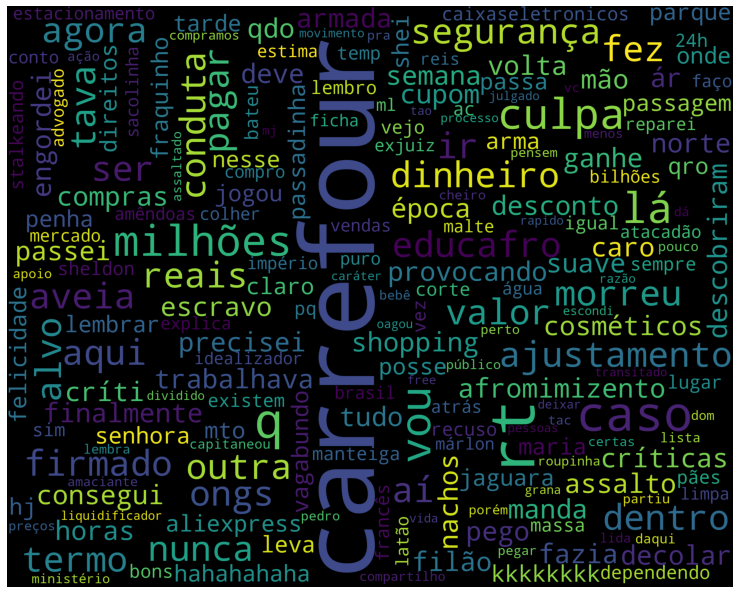

In [538]:
# 5.3 - gera o Wordlist
df = pd.DataFrame(tweets, columns= ['tweets', 'clean_tweets'])
df = df.drop_duplicates(subset='clean_tweets')

twt = " ".join(df['clean_tweets'])
wordcloud = WordCloud(stopwords=STOPWORDS, background_color='black', width=2500, height=2000).generate(twt)

plt.figure(1,figsize=(13, 13))
plt.imshow(wordcloud)
plt.axis('off')
plt.savefig('xpto4',bbox_inches='tight')
plt.show()
plt.close()

In [539]:
# 5.4 - Fim do Script!!! Yeah!!!
print("sucesso")

sucesso
